In [ ]:
# !pip install imbalanced-learn
# !pip install transformers
# !pip install torch
# !pip install tqdm
# !pip install catboost

import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/MRP/merged_eda_output.xls'

In [ ]:
df = pd.read_csv(file_path)
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,churned,delivery_delay
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,True,-8.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,True,-8.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,True,-8.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,2018-07-26 03:24:00,2018-07-26 14:31:00,2018-08-07 15:27:00,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,True,-6.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,2018-08-08 08:55:00,2018-08-08 13:50:00,2018-08-17 18:06:00,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto,True,-18.0


In [ ]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
last_date = df['order_purchase_timestamp'].max()

# Compute avg_days_between_orders
repeat_df = df[df.duplicated('customer_unique_id', keep=False)].copy()
repeat_df = repeat_df.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
repeat_df['prev_order'] = repeat_df.groupby('customer_unique_id')['order_purchase_timestamp'].shift()
repeat_df['days_between_orders'] = (repeat_df['order_purchase_timestamp'] - repeat_df['prev_order']).dt.days
avg_days_between = repeat_df.groupby('customer_unique_id')['days_between_orders'].mean().reset_index()
avg_days_between.columns = ['customer_unique_id', 'avg_days_between_orders']

# Engineered features
structured = df.groupby('customer_unique_id').agg({
    'payment_value': ['sum', 'mean'],
    'review_score': 'mean',
    'delivery_delay': 'mean',
    'product_category_name_english': pd.Series.nunique,
    'churned': 'first'
}).reset_index()

structured.columns = ['customer_unique_id', 'total_payment', 'avg_payment',
                      'avg_review_score', 'avg_delivery_delay', 'product_diversity',
                      'churned']

# merge average_days_between_orders into features
structured = structured.merge(avg_days_between, on='customer_unique_id', how='left')
structured['avg_days_between_orders'] = structured['avg_days_between_orders'].fillna(0)

In [ ]:
tqdm.pandas()

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Combine all reviews per customer into a single review string
review_data = df.groupby('customer_unique_id')['review_comment_message'].apply(
    lambda x: ' '.join(str(s) for s in x)
).reset_index()

review_data.columns = ['customer_unique_id', 'full_review']

# Sentinment scoring function
def classify_sentiment(text):
    try:
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
        with torch.no_grad():
            output = model(**encoded_input)
        scores = output.logits.detach().cpu().numpy()
        scores = softmax(scores, axis=1)[0]
        sentiment_idx = np.argmax(scores)  # 0=negative, 1=neutral, 2=positive
        label_map = {-1: 0, 0: 1, 1: 2}
        return sentiment_idx - 1  # Map 0,1,2 to -1,0,+1
    except:
        return 0

review_data['sentiment_score'] = review_data['full_review'].progress_apply(lambda x: classify_sentiment(str(x)))

df = df.merge(review_data[['customer_unique_id', 'sentiment_score']], on='customer_unique_id', how='left')

# Sentiment features
sentiment = df.groupby('customer_unique_id').agg({
    'sentiment_score': ['mean', 'std'],
    'review_comment_message': 'count'
}).reset_index()

sentiment.columns = ['customer_unique_id', 'avg_sentiment', 'sentiment_std', 'review_count']


# Structured data with sentiment
with_sentiment = structured.merge(sentiment, on='customer_unique_id', how='left')
with_sentiment[['avg_sentiment', 'sentiment_std']] = with_sentiment[['avg_sentiment', 'sentiment_std']].fillna(0)

# Structured data without sentiment
without_sentiment = structured.copy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

  0%|          | 0/95420 [00:00<?, ?it/s]


====== WITHOUT SENTIMENT ======

 - Logistic Regression:
              precision    recall  f1-score   support

       False       0.32      0.87      0.47       373
        True       1.00      0.98      0.99     28253

    accuracy                           0.97     28626
   macro avg       0.66      0.92      0.73     28626
weighted avg       0.99      0.97      0.98     28626

ROC-AUC: 0.9771537701896755

 - Random Forest:
              precision    recall  f1-score   support

       False       0.51      0.82      0.63       373
        True       1.00      0.99      0.99     28253

    accuracy                           0.99     28626
   macro avg       0.76      0.90      0.81     28626
weighted avg       0.99      0.99      0.99     28626

ROC-AUC: 0.9779923249982989

 - CatBoost:
              precision    recall  f1-score   support

       False       0.51      0.80      0.62       373
        True       1.00      0.99      0.99     28253

    accuracy                       

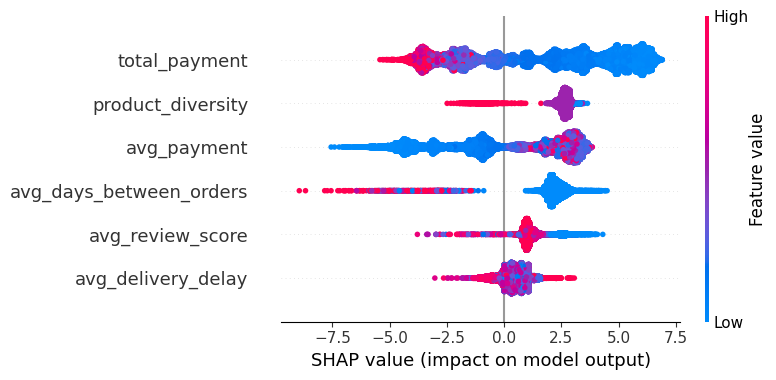


====== SHAP for CatBoost WITH Sentiment ======


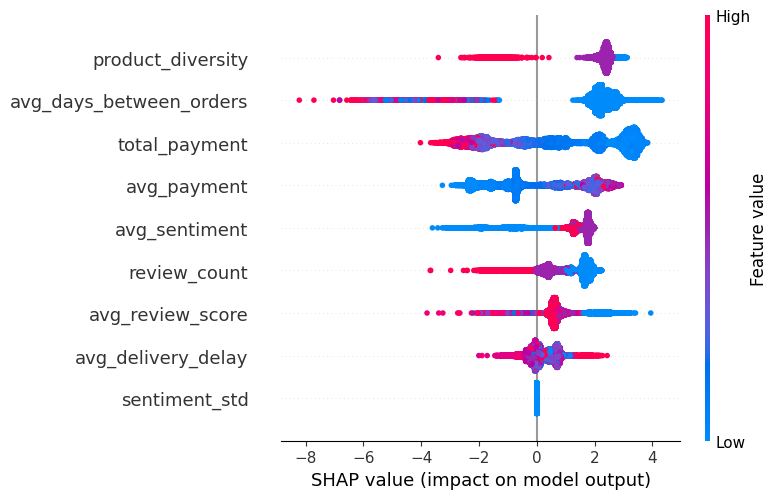

In [ ]:
# Prepare the data (70/30 split and SMOTE)
def prepare_data(df):
    X = df.drop(columns=['customer_unique_id', 'churned'])
    y = df['churned']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    imputer = SimpleImputer(strategy='mean')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    return X_train_res, X_test, y_train_res, y_test, X.columns

# Split with and without sentiment
X_train_wos, X_test_wos, y_train_wos, y_test_wos, cols_wos = prepare_data(without_sentiment)
X_train_ws, X_test_ws, y_train_ws, y_test_ws, cols_ws = prepare_data(with_sentiment)

# Training and eval
def train_models(X_train, X_test, y_train, y_test):
    lr = LogisticRegression(max_iter=1000)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    cat = CatBoostClassifier(verbose=0, random_state=42)

    models = {'Logistic Regression': lr, 'Random Forest': rf, 'CatBoost': cat}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]
        print(f"\n - {name}:")
        print(classification_report(y_test, preds))
        print("ROC-AUC:", roc_auc_score(y_test, probs))

    ensemble = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('cat', cat)], voting='soft')
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    y_proba = ensemble.predict_proba(X_test)[:, 1]
    print("\n - Ensemble:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

    return cat, X_test

print("\n          WITHOUT SENTIMENT")
cat_wos, X_test_wos_final = train_models(X_train_wos, X_test_wos, y_train_wos, y_test_wos)

print("\n          WITH SENTIMENT")
cat_ws, X_test_ws_final = train_models(X_train_ws, X_test_ws, y_train_ws, y_test_ws)

# SHAP, without sentiment, on CatBoost
print("\n          SHAP for CatBoost WITHOUT Sentiment")
explainer_wos = shap.TreeExplainer(cat_wos)
shap_values_wos = explainer_wos.shap_values(X_test_wos_final)
shap.summary_plot(shap_values_wos, features=X_test_wos_final, feature_names=cols_wos)

# SHAP, with sentiment, on CatBoost
print("\n          SHAP for CatBoost WITH Sentiment")
explainer_ws = shap.TreeExplainer(cat_ws)
shap_values_ws = explainer_ws.shap_values(X_test_ws_final)
shap.summary_plot(shap_values_ws, features=X_test_ws_final, feature_names=cols_ws)